# Computer Vision - Assignment 2 - Deep Learning for Computer Vision

### Student's Full Name: Anna Ivanchenko

The goal of this assignment is to learn how to implement and use Convolutional Neural Networks using the fastai library (https://docs.fast.ai/).

The goal of this assignmnet is to gain experience designing and training deep neural networks (in particular, convolutional neural networks). From a base network architecture that is provided, you have to learn to perform experiments with it and to improve it by adding, modifying or deleting layers.

A help guide (`Assignment_2_HG.ipynb`) is also provided to know how:
1. Basic functions of reading data, training and optimization can be performed;
2. Graphs for the evolution of the classification error in
the training and validation sets can be created;
3. The classification error in the test set can be computed.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

fastcore version 1.5.29 installed
fastai version 2.7.14 installed


In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# **Exercise 1: BaseNet in CIFAR100 (3 points)**

*Dataset:*
In this exercise, we will work with part of the CIFAR100 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). This dataset consists of 60K color images of 32x32x3 (RGB) depicting 100 different classes (600 images per class). There are 50K images for training and 10K for testing. For the development of the exercise we will only consider 25 classes (out of 100). Therefore, the training set has 12,500 images and the test set 2,500 images. 10% of the training set will be used for validation.

**Model BaseNet:**
We start by creating a base model called *BaseNet* which, after its training and execution, will give us a classification error which will be used as reference or baseline for further improvements.

Our BaseNet model consists of two convolutional blocks (Conv+ReLU) at different scales (MaxPooling), and one head composed of two fully-connected (FC) layers (also called dense layers). The precise architecture is defined in the table below:

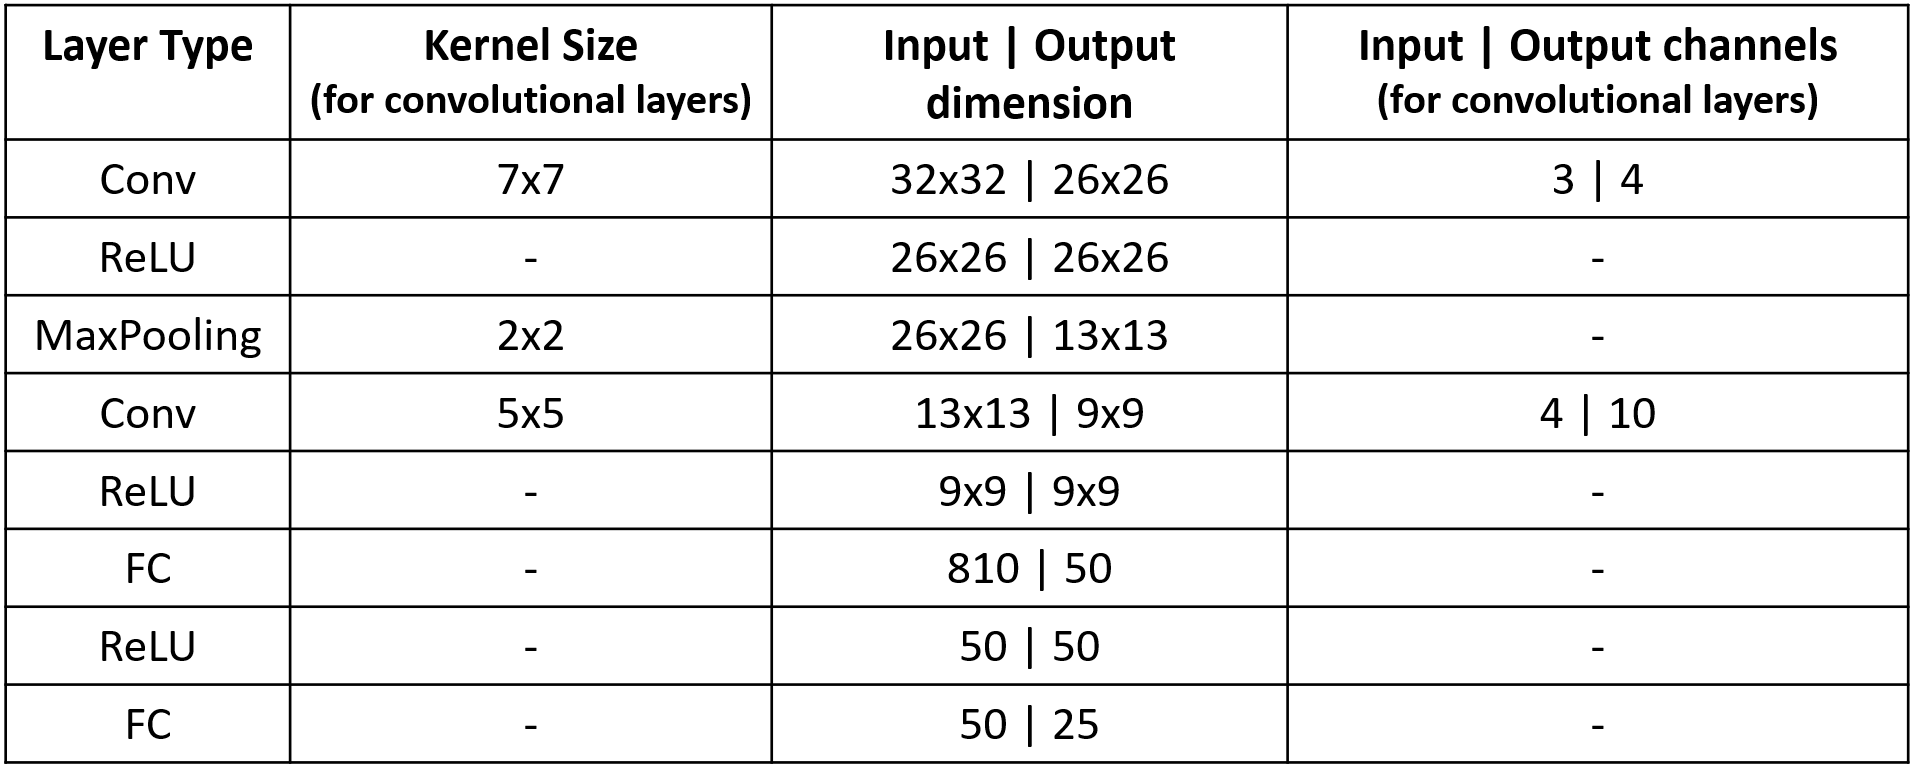


The students must:
1. Become familiar with the *BaseNet* architecture described above, the meaning of the different hyperparameters and the purpose of each layer. Create the code for the *BaseNet* model employing the fastai library.
2. Train the model (justifying all decisions made) and evaluate its performance. To do so, you should employ: the confusion matrix in training and testing; the accuracy in training, validation and test; and the evolution of both the loss function (in training and validation) and accuracy (in validation) with respect to the training epochs.

Note: This is the base model that we will try to improve in the next section. In this sense, it is not necessary to carry out a very sophisticated or complex training procedure. In any case, it is not advisable to use the default values of functions without having a justification for it. One must demonstrate that he/she understands what is doing, as well as what the framework does underneath.

In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/train'), Path('/root/.fastai/data/cifar100/test')]
[Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/trees'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/vehicles_2'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates'), Path('/root/.fastai/data/cifar100/train/reptiles'), Path('/root/.fastai/data/cifar100/train/food_containers'), Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/flowers'), Path('/roo


"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)." https://github.com/fastai/dlcert2/blob/master/docs/datasets.md

In [ ]:
# We want to verify that within each of the 20 superclasses there are 5 classes,
# which gives the 100 classes there are. We also want to verify that the number of images is correct
print('Classes within the first superclass (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Number of classes within superclass ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Classes within the first superclass ( /root/.fastai/data/cifar100/train/small_mammals ):  [Path('/root/.fastai/data/cifar100/train/small_mammals/shrew'), Path('/root/.fastai/data/cifar100/train/small_mammals/mouse'), Path('/root/.fastai/data/cifar100/train/small_mammals/rabbit'), Path('/root/.fastai/data/cifar100/train/small_mammals/hamster'), Path('/root/.fastai/data/cifar100/train/small_mammals/squirrel')]
Number of classes within superclass  0 :  5
Number of classes within superclass  1 :  5
Number of classes within superclass  2 :  5
Number of classes within superclass  3 :  5
Number of classes within superclass  4 :  5
Number of classes within superclass  5 :  5
Number of classes within superclass  6 :  5
Number of classes within superclass  7 :  5
Number of classes within superclass  8 :  5
Number of classes within superclass  9 :  5
Number of classes within superclass  10 :  5
Number of classes within superclass  11 :  5
Number of classes within superclass  12 :  5
Number of cla

In [ ]:
# We keep the first 25 classes (we remove the last 75 from the dataset)
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('REMOVED SUPERCLASSES:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASSES WE KEEP:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

REMOVED SUPERCLASSES:
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/reptiles
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/train/medium_mammals
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/large_carnivores
SUPERCLASSES WE KEEP:
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/trees
/root/.fastai/data/cifar100/train/aquatic_mammals
/root/.fastai/data/cifar100/train/large_man-made_outd

In [ ]:
# We also remove the classes from the test set
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/vehicles_2
/root/.fastai/data/cifar100/test/fish
/root/.fastai/data/cifar100/test/non-insect_invertebrates
/root/.fastai/data/cifar100/test/reptiles
/root/.fastai/data/cifar100/test/food_containers
/root/.fastai/data/cifar100/test/insects
/root/.fastai/data/cifar100/test/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/test/medium_mammals
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/household_furniture
/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/large_carnivores


In [ ]:
# Now we check if we have remove them correctly
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


In [ ]:
# And that the number of examples in training and test is correct
print('Classes within the first superclass (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Classes within the first superclass ( /root/.fastai/data/cifar100/train/small_mammals ):  [Path('/root/.fastai/data/cifar100/train/small_mammals/shrew'), Path('/root/.fastai/data/cifar100/train/small_mammals/mouse'), Path('/root/.fastai/data/cifar100/train/small_mammals/rabbit'), Path('/root/.fastai/data/cifar100/train/small_mammals/hamster'), Path('/root/.fastai/data/cifar100/train/small_mammals/squirrel')]
Total training images:  12500
Total test images:  2500


## **Description of the BaseNet for CIFAR-100 Classification**

 **Introduction**

In this section, I will desribe steps performed to create BaseNet with the part of the CIFAR100 dataset (25 classes) for image classification. This BaseNet model consists of two convolutional blocks (Conv+ReLU) at different scales (MaxPooling), and one head composed of two fully-connected (FC) layers.

**1. Load the Data (Datablock/Dataloaders)**

- **Data Preprocessing:**
  - We load images from the CIFAR-100 dataset.
  - The dataset contains 12,500 training images and 2,500 validation images.
  - Labels are extracted from folder names (parent directories).

- **Data Augmentation:**
  - We apply data augmentation techniques during training to increase dataset diversity.
  - Augmentations include random zoom, rotation, and horizontal flip.

**2. Network (Model Architecture)**

- **BaseNet Architecture:**
  - Our BaseNet consists of the following layers:
      1. **Convolutional Layer 1**:
          - 3 input channels (RGB images).
          - 4 output channels (filters).
          - Kernel size: 7x7.
      2. **ReLU Activation**:
          - Introduces non-linearity.
      3. **Max Pooling**:
          - Reduces spatial dimensions.
      4. **Convolutional Layer 2**:
          - 4 input channels (from previous layer).
          - 10 output channels.
          - Kernel size: 5x5.
      5. **ReLU Activation**.
      6. **Flatten Layer**:
          - Converts the output to a 1D tensor.
      7. **Fully Connected Layer 1**:
          - 810 input features.
          - 50 output features.
      8. **ReLU Activation**.
      9. **Fully Connected Layer 2**:
          - Final output features (25 classes).

This is a multiclass classification problem, and in this case the most natural/common choice for the activation function will be SoftMax, and for loss function - cross-entropy loss. Nevertheless, as SoftMax is already included in the cross-entropy loss function in Python, there is no need to include it in the network.

 **3. Create the Learner**

- **Model Training:**
  - We create a Learner object that combines:
      - Data (dataloader).
      - Model (BaseNet).
      - Loss function (cross-entropy).
      - Accuracy metric.

 **4. Training (FiT)**

- **Training Process:**
  - We train the model using the fit method.
  - The model learns to minimize the cross-entropy loss during training.

 **5. Prediction & Analysis**

- **Model Evaluation:**
  - After training, we evaluate the model on the validation set.
  - Metrics include accuracy and loss.
  - We analyze the confusion matrix to understand class-wise performance.

epoch,train_loss,valid_loss,accuracy,time
0,2.642559,2.619809,0.185667,00:44
1,2.466468,2.422979,0.249000,00:24
2,2.311516,2.269064,0.278667,00:24
3,2.278371,2.249764,0.289333,00:24
4,2.196574,2.194704,0.302667,00:25
5,2.189413,2.193714,0.308667,00:27
6,2.207086,2.158977,0.312333,00:24
7,2.125323,2.126953,0.315000,00:24
8,2.083559,2.134711,0.312333,00:42
9,2.083807,2.151761,0.309000,00:34


Validation loss: 2.151761293411255
Validation accuracy: 0.3089999854564667


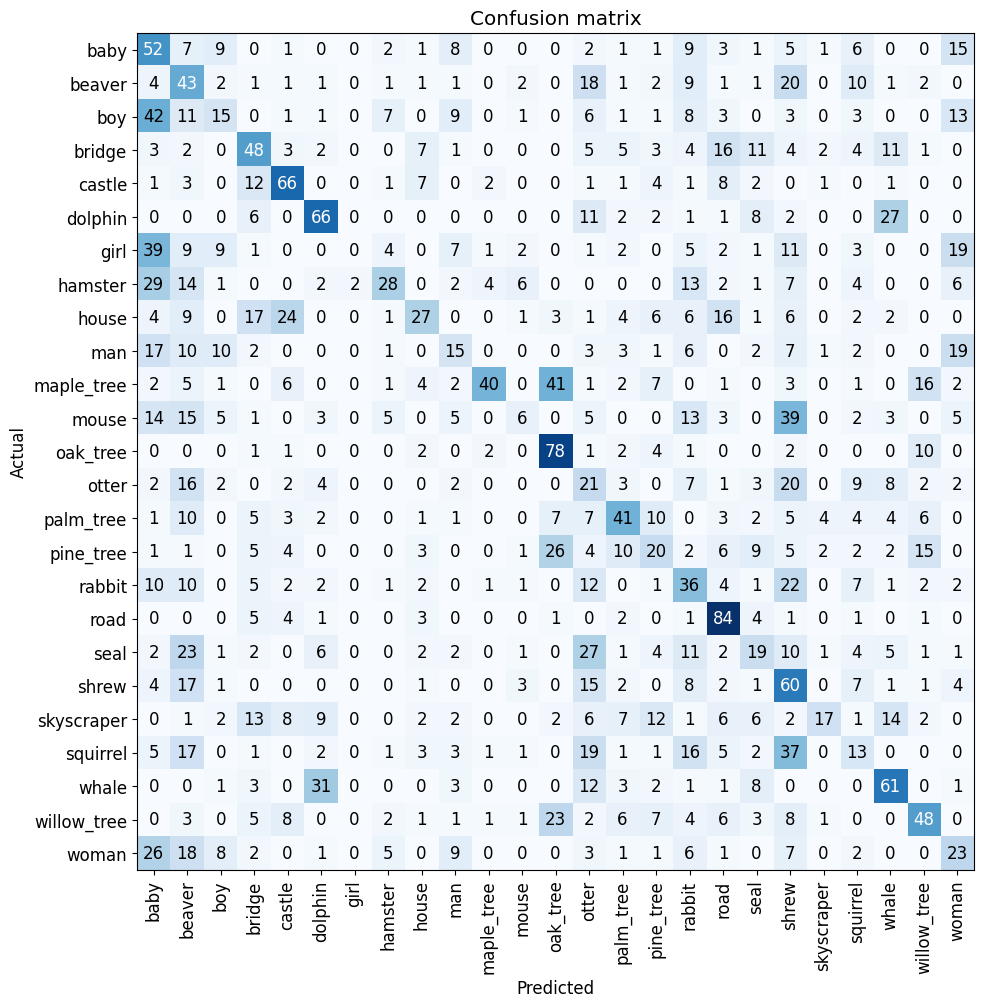

In [ ]:
'''
BaseNet

# 1. Load the Data: Datablock/dataloaders (4-5 lines)
# 2. Network (5 lines)
# 3. You create your learner (combination of dataloader, network, loss-function, metric, optimizer) (1 line)
# 4. FiT (training) (1 line)
# 5. Prediction & Analysis of the results obtained
'''

# Define data paths
path = untar_data(URLs.CIFAR_100, force_download=False)  # Use cached version if available

# Define data block and create data loaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # The inputs for our model will be images (ImageBlock) and the outpust are categories (CategoryBlock)
    get_items=get_image_files, # We retrieve the images using the get_image_files function, which returns a list with all the images in path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # We split the data randomly between training and validation (20%).
    # We set the random seed to partition the data always in the same way.
    get_y=parent_label, # The labels (desired outputs) are obtained from the name of the parent directory of each file
).dataloaders(path, bs=32) # All this process will be performed on the images/folders in path.
# And the images will be loaded in batches (bs) of 32.

# We can also apply data normalization inside of the datablock

# Define BaseNet architecture
BaseNet = sequential(
# Convolutional layer 1: Applies a 2D convolution over an input signal composed of several input planes.
    # Here, we have 3 input channels (RGB), 4 output channels (filters), and a kernel size of 7x7.
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(7,7)),
    # ReLU activation: Applies the rectified linear unit function element-wise.
    # It introduces non-linearity to the model, allowing it to learn more complex functions.
    nn.ReLU(),
    # Max pooling: Applies a 2D max pooling over an input signal composed of several input planes.
    # It reduces the spatial size of the representation, reducing the number of parameters and computation in the network.
    nn.MaxPool2d(kernel_size=(2,2)),
    # Convolutional layer 2: A second convolutional layer with 4 input channels (from the previous layer),
    # 10 output channels, and a kernel size of 5x5.
    nn.Conv2d(in_channels=4, out_channels=10, kernel_size=(5, 5)),
    # ReLU activation function.
    nn.ReLU(),
    # Flatten: Flattens the output of the convolutional layers to a 1D tensor to be fed into the fully connected layers.
    nn.Flatten(),
    # Fully connected layer 1: A linear layer with 810 input features (from the flattened layer) and 50 output features.
    nn.Linear(in_features=810, out_features=50),
    # ReLU activation function.
    nn.ReLU(),
    # Fully connected layer 2: The final linear layer that outputs 25 features, corresponding to the number of classes in our subset of CIFAR100.
    nn.Linear(in_features=50, out_features=25),
    # Softmax is unnecessary as the CrossEntropyLoss function already includes softmax.
)

# Learner object includes the model (BaseNet), the data (dls) and the loss function (loss_func)
learn = Learner(dls, BaseNet, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# Verify
learn.summary()

# Train the model for 10 epochs
# We chose 10 epochs as a starting point to observe the training behavior without overfitting.
learn.fit(10)

# Validate the model and print the accuracy
val_loss, val_accuracy = learn.validate()
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

# Plot the confusion matrix for the validation set
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

The model's accuracy currently stands at approximately 30%. This low accuracy may be attributed to the network's narrow architecture. The model output is small, resulting in limited feature extraction capability.

Our BaseNet model acts as a starting point for further enhancements. In the upcoming section, I'll explore potential areas for growth and improvement.

What is the total number of parameters of the created model? Break down the account made to reach that figure.



## **Total number of parameters in the network:**

1. **Conv2d Layer**:
    Kernel size is 7x7x3, 4 filters is used as we have 4 output channels
    - Each level has 7x7x3 + 1 (bias) = 148 parameters
    - We have 4 filters: 148x4 = 592 in total

2. **ReLU Activation Layer**
    - No parameters inctroduced

3. **MaxPool2d Layer**:
    - No parameters inctroduced

4. **Conv2d Layer**:
    Kernel size is 5x5x4, 10 filters is used as we have 10 output channels
    - Each level has 5x5x4 + 1 (bias) = 101 parameters
    - We have 10 filters: 101x10 =  1010

5. **ReLU Activation Layer (after Conv2d)**
    - No parameters inctroduced

6. **Fully Connected Layer (Flatten Layer and Linear Layer)**:
    We have input dimension = 810, output dimention = 50
    - Number of parameters: 810 x 50 + 50 (bias) = 40,550

7. **ReLU Activation Layer (after 5th Linear)**
    - No parameters inctroduced

8. **Fully Connected Layer (Linear Layer)**:
    We have input dimension = 50, output dimention = 25
    - Number of parameters: 50 x 25 = 1275

**Total number of parameters in the network**: **592 + 1010 + 40,550 + 1275 = 43,427**

**Question:** When fastai is used, and a multiclass classification problem like the one indicated in this exercise is addressed, is it necessary to incorporate a SoftMax function (`nn.Softmax()`) as last layer/element/component of your model? Justify the answer.

**Answer:**
No, it is not necessary to incorporate a SoftMax function (`nn.Softmax()`) as the last layer of the BaseNet model in this situation, because fastai automatically handles the SoftMax activation internally in its default loss function, which is set to `CrossEntropyLossFlat()`.

In multiclass classification tasks, the Cross-Entropy Loss effectively merges the SoftMax activation and negative log likelihood into one simple process. The SoftMax function transforms raw model predictions into probabilities for each class, guaranteeing they add up to 1 for all classes. The default setting in Fastai incorporates this SoftMax activation when calculating the loss, eliminating the need for separate SoftMax layers.



---



---



---



**Exercise 2:** **Improvement of the BaseNet model (3.5 points)**
Now the goal is to create, by making judicious architectural and implementation choices, an enhanced deep network based on *BaseNet*. Students should perform a sensible combination of different elements, which may include all or some of the following: Convolutional layers (Conv2D, either normal or atrous), Pooling layers (Local and Global MaxPooling2D and AveragePooling2D), Dense layers (also called fully-connected (FC) layers), Non-linear activations, (e.g. ReLu, leaky ReLu, etc.), Flattening (i.e. convert 2D features to 1D features),  Batch Normalization, and/or Regularization (e.g. Dropout or weight decay).

It is necessary to emphasize that **it is essential to justify the decisions made in the best possible way** (either through empirical evidence or through scientific literature). It is also essential to highlight that **the improvements made must be carried out incrementally**, that is, it is not enough to create a single model directly and evaluate it. **It is necessary to justify and describe what steps and results have led us to conclude that this model (specific combination of constituent blocks) is appropriate**. It is absolutely essential to describe each of the improvements incorporated, as well as analyze the results obtained.

A good combination of layers can largely improve the performance of our new model on these data. To enhance your network, you may consider adding any combination of the following enhancement options:
1. **Data normalization**. Scale normalization of the input data, in general, makes training easier and more robust. Use the DataBlock class with the correct parameters so that the data is well conditioned (mean=0, stddev=1) to improve training. You must ensure that the test set uses the same normalization parameters as the ones employed in training.
2. **Batch normalization**. Batch-normalization layers in most cases help to reduce overfitting and improve model training. Add normalization layers after convolutional layers and before the ReLU layer, but try including it after ReLU layers as well.
3. **Depth increase**. Experiment adding convolutional layers. Do not always put a maxpool layer after each conv layer, as this leads to excessive loss of information by reducing the number of units. If needed use UpSampling (Transposed Convolution) layers to increase the number of units.
4. **Dropout**. This layer introduces regularization by randomly selecting a percentage of active neurons for each mini-batch. This helps the network to specialize neurons in specific and independent information.
5. **Early Stopping**. After how many epochs we should stop training? Keep in mind that you should never use the test set for anything other than the final evaluation. You should decide for how many epochs you will train your model by looking at the training loss and validation accuracy plots (to do so, evaluate the local minima/maxima of the loss function as well as the classification accuracy). Remember that if you choose too many epochs it would quite likely lead to overfitting, while if you select too few your model quite likely won't  learn enough. In your report, you must include a table similar to the one shown in Exercise 1 to illustrate the architecture of your final improved network. In addition, you must explain the steps taken with the partial results obtained that have finally led you to introduce the proposed modifications.
6. **Data augmentation**.  Use the DataBlock class to perform data augmentation, like zoom_range and/or horizontal_flip. Remember that, in general, you should not have any data augmentation in the validation or test sets.

Feel free to incorporate modifications not included in the aforementioned list.

**In this exercise I tried different combinations of the enhancement techiques and network architecture, which gave me an opportunity to improve accuracy from 30% to almost 50%. Here, I will present 7 of my models and justify performed moderations.**

## **Improved BaseNet #1**

In this step, in addition to the BaseNet, depeloped in the exercise 1, and incorporated the Data Normalization. Here is the structure:

1. **Data Preparation and Loading**:
    - We define the data path using `untar_data` to access the CIFAR-100 dataset.
    - Next, we create a `DataBlock`:
        - The input data consists of images (RGB channels), and the output labels are categories.
        - We retrieve the image files using `get_image_files`.
        - We randomly split the data into training and validation sets (80% training, 20% validation) using `RandomSplitter`.
        - The labels are obtained from the parent directory names.
        - We apply data normalization using ImageNet statistics.

2. **BaseNet Architecture**:
    - `BaseNet` is defined as a sequential neural network:
        - Convolutional Layer 1:
            - 3 input channels (RGB).
            - 4 output channels (filters).
            - Kernel size: 7x7.
        - ReLU activation.
        - Max pooling (2x2).
        - Convolutional Layer 2:
            - 4 input channels (from the previous layer).
            - 10 output channels.
            - Kernel size: 5x5.
        - ReLU activation.
        - Flatten the output.
        - Fully connected Layer 1:
            - 810 input features (flattened layer).
            - 50 output features.
        - ReLU activation.
        - Fully connected Layer 2:
            - Outputs 25 features (corresponding to CIFAR-100 classes).

3. **Create the Learner**:
    - We create a `Learner` object that combines the model (`BaseNet`), data (`dls`), loss function (`CrossEntropyLossFlat()`), and accuracy metric.

4. **Training**:
    - We train the model for 10 epochs.

5. **Validation and Analysis**:
    - We validate the model and print the validation loss and accuracy.
    - We plot the confusion matrix for the validation set.

epoch,train_loss,valid_loss,accuracy,time
0,2.421646,2.361202,0.265000,00:23
1,2.271768,2.235215,0.284000,00:25
2,2.210219,2.188084,0.295000,00:26
3,2.133383,2.136780,0.318000,00:25
4,2.079219,2.098341,0.323333,00:23
5,2.011472,2.105067,0.324000,00:25
6,1.978850,2.104348,0.331333,00:25
7,1.949034,2.102194,0.329000,00:25
8,1.880328,2.097367,0.338333,00:24
9,1.817805,2.066667,0.343333,00:25


Validation loss: 2.066666841506958
Validation accuracy: 0.34333333373069763


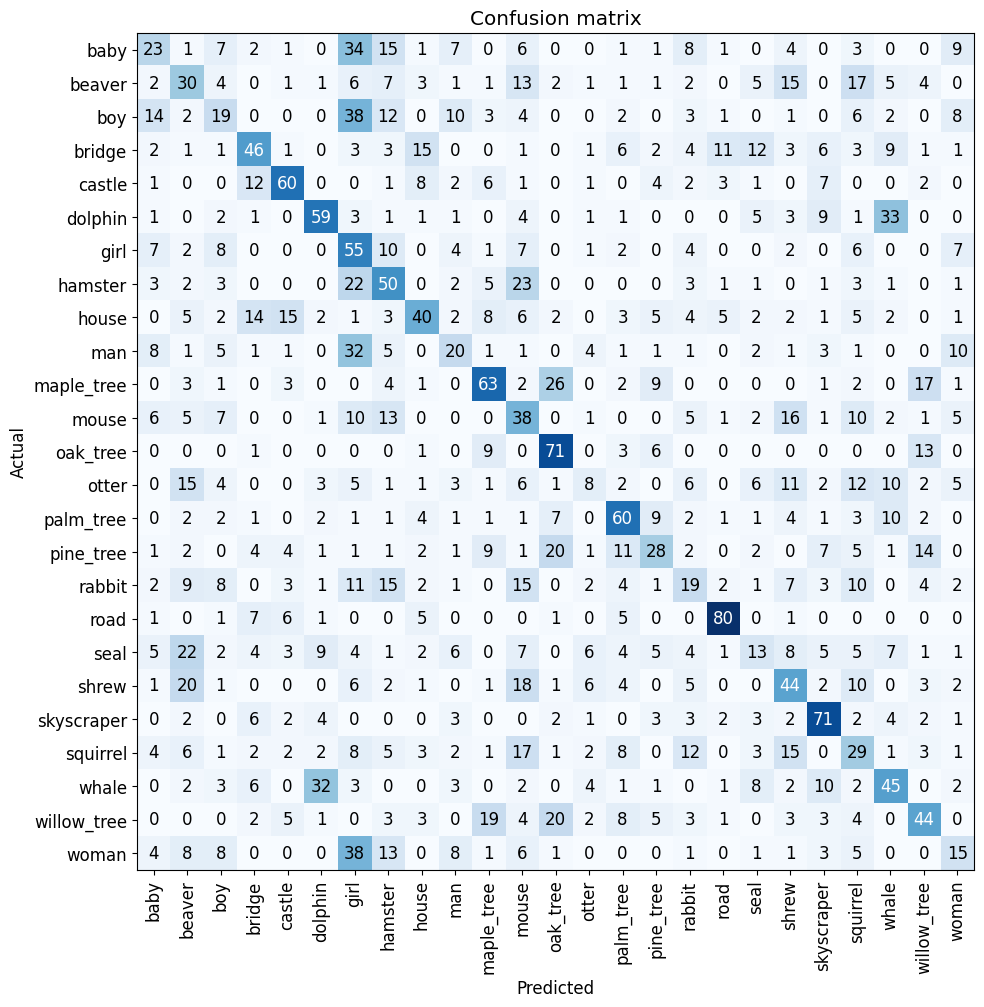

In [ ]:
'''
Improved BaseNet #1

Technique Imployed:
- Data Normalization
'''

# Define data paths
path = untar_data(URLs.CIFAR_100, force_download=False)  # Use cached version if available

# Define data block and create data loaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # The inputs for our model will be images (ImageBlock) and the outpust are categories (CategoryBlock)
    get_items=get_image_files, # We retrieve the images using the get_image_files function, which returns a list with all the images in path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # We split the data randomly between training and validation (20%).
    # We set the random seed to partition the data always in the same way.
    get_y=parent_label, # The labels (desired outputs) are obtained from the name of the parent directory of each file
    batch_tfms=Normalize.from_stats(*imagenet_stats)  # We apply normalization using ImageNet statistics
).dataloaders(path, bs=32) # All this process will be performed on the images/folders in path.
# And the images will be loaded in batches (bs) of 32.

# We can also apply data normalization inside of the datablock

# Define BaseNet architecture
BaseNet = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(7,7)), # Convolutional layer 1
    nn.ReLU(), # # ReLU activation: Here we have a volume of 26x26x5
    nn.MaxPool2d(kernel_size=(2,2)), # Max pooling
    nn.Conv2d(in_channels=4, out_channels=10, kernel_size=(5, 5)),  # Convolutional layer 2
    nn.ReLU(),  # ReLU activation
    nn.Flatten(), # Here we have a volume of 9x9x10, i.e. 810 elements
    nn.Linear(in_features=810, out_features=50), # Fully connected layer 1
    nn.ReLU(),  # ReLU activation
    nn.Linear(in_features=50, out_features=25),  # Fully connected layer 2
    # nn.Softmax() is unnesessary as crossentropy already uses softmax
)

# Learner object includes the model (simpleNet), the data (dls) and the loss function (loss_func)
learn = Learner(dls, BaseNet, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# Verify
learn.summary()

# Train the model (here we train for 10 epochs)
learn.fit(10)

# Validate the model and print the accuracy
val_loss, val_accuracy = learn.validate()
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

# Plot the confusion matrix for the validation set
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

*After applying data normalization, we observed a modest improvement in model performance. The accuracy, which initially stood at 30%, now ranges between 33% and 34%. This enhancement demonstrates the effectiveness of data normalization in stabilizing training and improving convergence.*

## **Improved BaseNet #2**

In this section I will describe the steps performed in improved `BaseNet #2` with data augmentation:

1. **Data Augmentation**:
    - Data augmentation is a technique used to artificially increase the size of the training dataset by applying various transformations to the original images.
    - The goal is to improve the model's generalization by exposing it to a wider range of variations in the data.
    - Standard sets of data augmentation techniques include:
        - **Random Flips**: Horizontally or vertically flip the image.
        - **Random Rotations**: Rotate the image by a random angle.
        - **Random Zooms**: Zoom in or out of the image.
        - **Random Crops**: Crop a random portion of the image.
        - **Brightness and Contrast Adjustments**: Change the brightness and contrast levels.
        - **Color Jittering**: Introduce small random changes to the color channels.
    - By applying these transformations, the model becomes more robust to variations in lighting, orientation, and other factors.

2. **Network Architecture (BaseNet)**:
    - `BaseNet` is remains the same:
        - **Convolutional Layer 1**:
            - 3 input channels (RGB).
            - 4 output channels (filters).
            - Kernel size: 7x7.
        - **ReLU Activation**.
        - **Max Pooling** (2x2).
        - **Convolutional Layer 2**:
            - 4 input channels (from the previous layer).
            - 10 output channels.
            - Kernel size: 5x5.
        - **ReLU Activation**.
        - **Flatten** the output.
        - **Fully Connected Layer 1**:
            - 810 input features (flattened layer).
            - 50 output features.
        - **ReLU Activation**.
        - **Fully Connected Layer 2**:
            - Outputs 25 features (corresponding to CIFAR-100 classes).

3. **Learner Creation**:
    - We create a `Learner` object that combines the model (`BaseNet`), data (`dls`), loss function (`CrossEntropyLossFlat()`), and accuracy metric.
    - The learner encapsulates the entire training process.

4. **Training and Validation**:
    - We train the model for 10 epochs.
    - The training process involves updating the model's weights using backpropagation and gradient descent.
    - We validate the model on the validation set and print the validation loss and accuracy.

5. **Confusion Matrix**:
    - We visualize the confusion matrix to understand how well the model performs across different classes.
    - The confusion matrix shows the true positive, true negative, false positive, and false negative counts for each class.


epoch,train_loss,valid_loss,accuracy,time
0,2.713542,2.642411,0.185333,00:31
1,2.495859,2.368542,0.250333,00:31
2,2.363590,2.271964,0.268667,00:30
3,2.309806,2.300863,0.269000,00:30
4,2.276913,2.192786,0.309667,00:30
5,2.218184,2.146710,0.313333,00:30
6,2.216121,2.138510,0.308667,00:30
7,2.197832,2.072539,0.342667,00:31
8,2.137287,2.091461,0.342667,00:31
9,2.140166,2.080559,0.340667,00:30


Validation loss: 2.0805585384368896
Validation accuracy: 0.34066668152809143


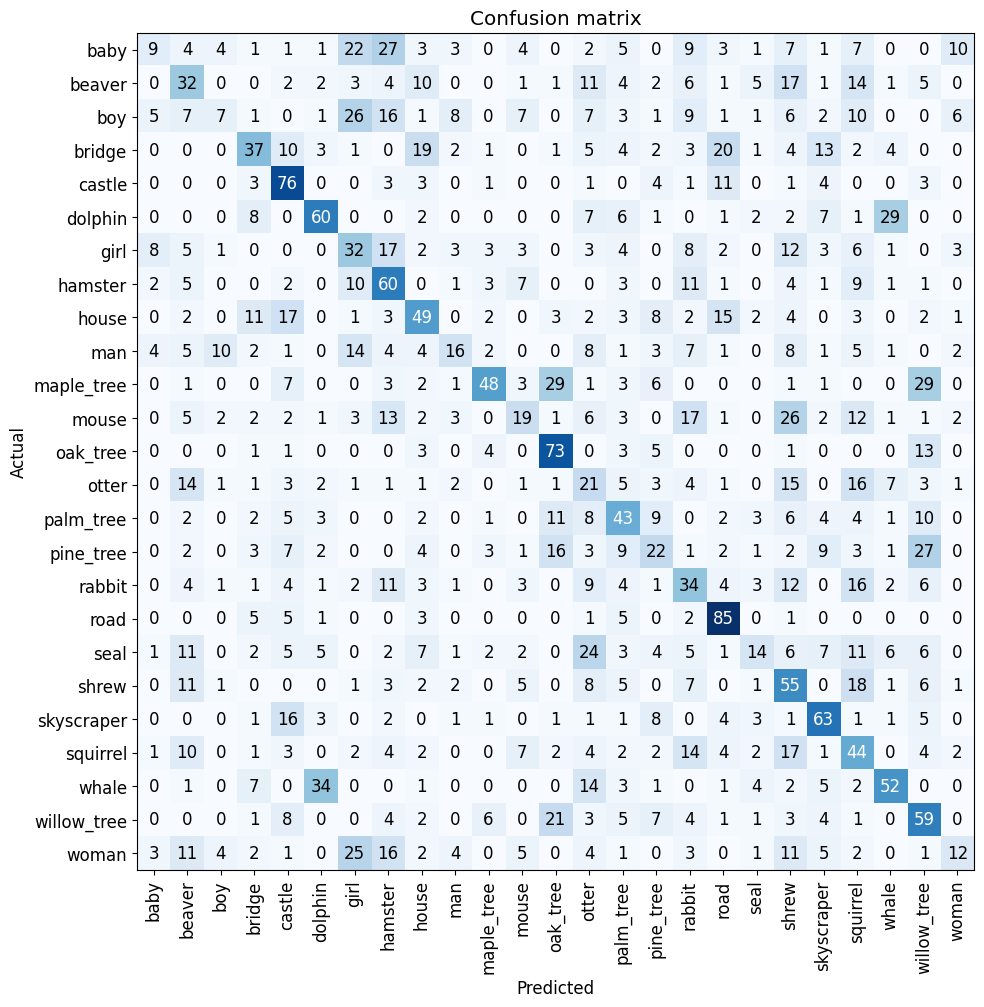

In [ ]:
# To be completed by the students
'''
Improved BaseNet #2

Technique Imployed:
- Data Augmentation
'''

# Define data paths
path = untar_data(URLs.CIFAR_100, force_download=False)  # Use cached version if available

# Define data block and create data loaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # The inputs for our model will be images (ImageBlock) and the outpust are categories (CategoryBlock)
    get_items=get_image_files, # We retrieve the images using the get_image_files function, which returns a list with all the images in path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # We split the data randomly between training and validation (20%).
    # We set the random seed to partition the data always in the same way.
    get_y=parent_label, # The labels (desired outputs) are obtained from the name of the parent directory of each file
    batch_tfms=aug_transforms() # We apply standard sets of Data Augmentation all at once
).dataloaders(path, bs=32) # All this process will be performed on the images/folders in path.
# And the images will be loaded in batches (bs) of 32.

# We can also apply data normalization inside of the datablock

# Define BaseNet architecture
BaseNet = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(7,7)), # Convolutional layer 1
    nn.ReLU(), # # ReLU activation: Here we have a volume of 26x26x5
    nn.MaxPool2d(kernel_size=(2,2)), # Max pooling
    nn.Conv2d(in_channels=4, out_channels=10, kernel_size=(5, 5)),  # Convolutional layer 2
    nn.ReLU(),  # ReLU activation
    nn.Flatten(), # Here we have a volume of 9x9x10, i.e. 810 elements
    nn.Linear(in_features=810, out_features=50), # Fully connected layer 1
    nn.ReLU(),  # ReLU activation
    nn.Linear(in_features=50, out_features=25),  # Fully connected layer 2
    # nn.Softmax() is unnesessary as crossentropy already uses softmax
)

# Learner object includes the model (simpleNet), the data (dls) and the loss function (loss_func)
learn = Learner(dls, BaseNet, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# Verify
learn.summary()

# Train the model (here we train for 10 epochs)
learn.fit(10)

# Validate the model and print the accuracy
val_loss, val_accuracy = learn.validate()
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

# Plot the confusion matrix for the validation set
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

*After data augmentation, we observe the result similiar to data normalization. The accuracywent from 30% to 33%. This enhancement demonstrates the effectiveness of data augmntation technique.*

## **Improved BaseNet #3**

In this section I implyed both Data Normalization and Data Augmentation at the same time. Here is the updated architecture:

1. **Network Architecture (BaseNet)**:
    - `BaseNet` remains the same as in the previous version:
        - Convolutional Layer 1: 3 input channels (RGB), 4 output channels (filters), and a 7x7 kernel size.
        - ReLU activation.
        - Max pooling (2x2).
        - Convolutional Layer 2: 4 input channels (from the previous layer), 10 output channels, and a 5x5 kernel size.
        - ReLU activation.
        - Flatten the output.
        - Fully connected Layer 1: 810 input features (flattened layer) and 50 output features.
        - ReLU activation.
        - Fully connected Layer 2: Outputs 25 features (corresponding to CIFAR-100 classes).

2. **Learner Creation and Training**:
    - We create a `Learner` object that encapsulates the entire training process.
    - The model is trained for 10 epochs.
    - We validate the model on the validation set and print the validation loss and accuracy.

3. **Confusion Matrix**:
    - We visualize the confusion matrix to assess the model's performance across different classes.

epoch,train_loss,valid_loss,accuracy,time
0,2.520273,2.376102,0.242667,00:30
1,2.323733,2.251323,0.287333,00:30
2,2.266234,2.188087,0.301000,00:32
3,2.228286,2.121501,0.318333,00:31
4,2.186150,2.091833,0.337667,00:30
5,2.177331,2.080733,0.340667,00:31
6,2.119607,2.074524,0.343333,00:30
7,2.109611,2.069335,0.323000,00:30
8,2.112886,2.010005,0.353333,00:31
9,2.041413,2.035313,0.335667,00:31


Validation loss: 2.0353126525878906
Validation accuracy: 0.3356666564941406


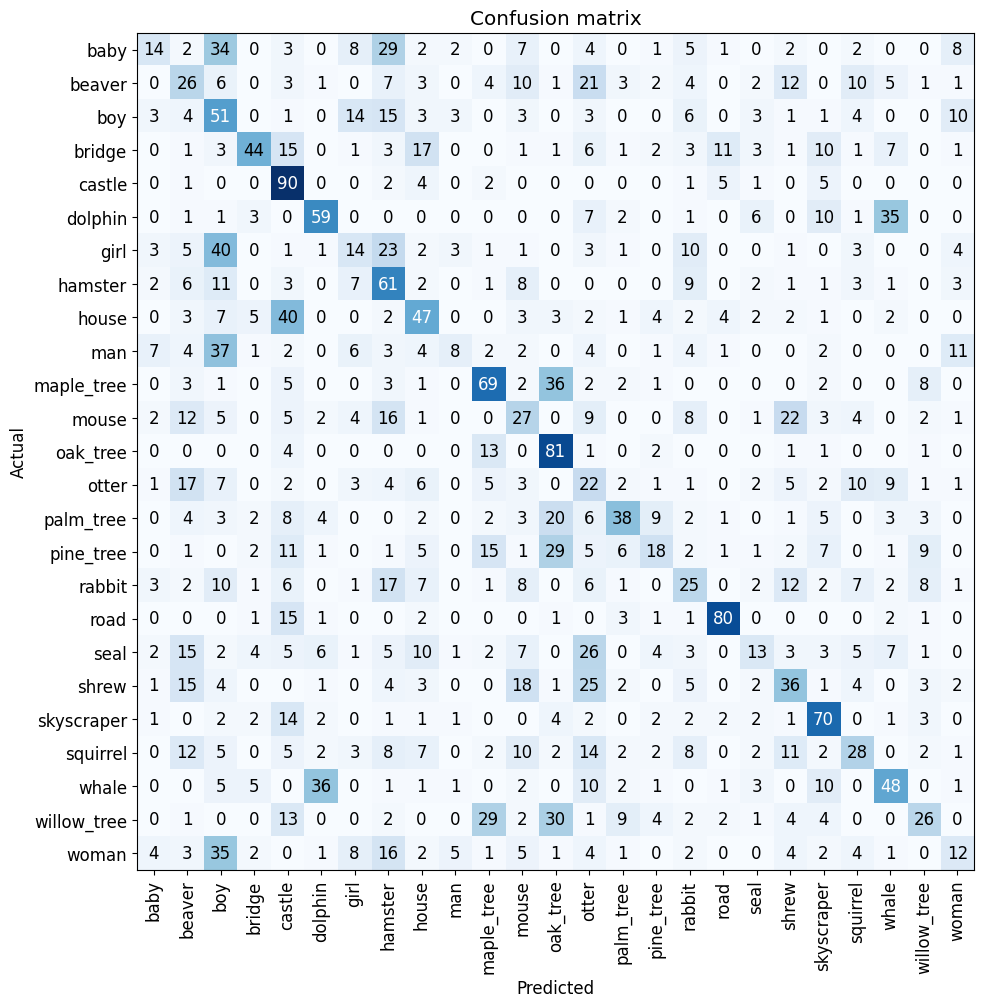

In [ ]:
# To be completed by the students
'''
Improved BaseNet #3

Techniques Imployed:
- Data Normalization
- Data Augmentation
'''

# Define data paths
path = untar_data(URLs.CIFAR_100, force_download=False)  # Use cached version if available

# Define data block and create data loaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # The inputs for our model will be images (ImageBlock) and the outpust are categories (CategoryBlock)
    get_items=get_image_files, # We retrieve the images using the get_image_files function, which returns a list with all the images in path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # We split the data randomly between training and validation (20%).
    # We set the random seed to partition the data always in the same way.
    get_y=parent_label, # The labels (desired outputs) are obtained from the name of the parent directory of each file
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]  # Apply data augmentation and normalization
).dataloaders(path, bs=32) # All this process will be performed on the images/folders in path.
# And the images will be loaded in batches (bs) of 32.

# We can also apply data normalization inside of the datablock

# Define BaseNet architecture
BaseNet = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(7,7)), # Convolutional layer 1
    nn.ReLU(), # # ReLU activation: Here we have a volume of 26x26x5
    nn.MaxPool2d(kernel_size=(2,2)), # Max pooling
    nn.Conv2d(in_channels=4, out_channels=10, kernel_size=(5, 5)),  # Convolutional layer 2
    nn.ReLU(),  # ReLU activation
    nn.Flatten(), # Here we have a volume of 9x9x10, i.e. 810 elements
    nn.Linear(in_features=810, out_features=50), # Fully connected layer 1
    nn.ReLU(),  # ReLU activation
    nn.Linear(in_features=50, out_features=25),  # Fully connected layer 2
    # nn.Softmax() is unnesessary as crossentropy already uses softmax
)

# Learner object includes the model (simpleNet), the data (dls) and the loss function (loss_func)
learn = Learner(dls, BaseNet, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# Verify
learn.summary()

# Train the model (here we train for 10 epochs)
learn.fit(10)

# Validate the model and print the accuracy
val_loss, val_accuracy = learn.validate()
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

# Plot the confusion matrix for the validation set
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

*After combining both data augmentation and data normalization, we noticed that the result remained consistent compared to applying them separately. The accuracy still stands at 34%. This observation suggests that the combined effect of these techniques did not significantly alter the model's performance.*

## **Improved BaseNet #4**

For this section, I imployed Data Normalization, Data Augmentation, Batch Normalization and Dropout:

1. **Techniques Employed**:
    - **Data Normalization**:
        - Data normalization ensures that input features have similar scales.
        - We apply normalization using ImageNet statistics (mean and standard deviation).
        - Normalization stabilizes training and helps the model converge faster.
    - **Data Augmentation**:
        - Data augmentation introduces variations in the training data by applying transformations (e.g., flips, rotations, zooms).
        - It enhances the model's ability to generalize to unseen examples.
    - **Dropout**:
        - Dropout is a regularization technique.
        - During training, it randomly drops (sets to zero) a fraction of the neurons in a layer.
        - This prevents overfitting by encouraging the network to rely on multiple pathways.
        - In our model, we apply dropout with a 20% probability after the first linear layer.
    - **Batch Normalization**:
        - Batch normalization normalizes the output of a layer across a mini-batch of training examples.
        - It helps stabilize training by reducing internal covariate shift.
        - In our model, we apply batch normalization after the first linear layer.

3. **Architecture Details**:
    - **Convolutional Layers**:
        - Two convolutional layers with ReLU activations.
        - The first layer has 3 input channels (RGB) and 4 output channels.
        - The second layer has 4 input channels (from the previous layer) and 10 output channels.
    - **Flatten Layer**:
        - Flattens the output from the convolutional layers.
        - Results in a 1D vector of 810 elements.
    - **Fully Connected Layers**:
        - First fully connected layer with 810 input features and 50 output features.
        - ReLU activation applied.
        - Batch normalization after this layer.
        - Dropout with 20% probability.
        - Second fully connected layer with 50 input features and 25 output features.

4. **Learner Creation and Training**:
    - We create a `Learner` object that combines the model architecture, data loaders, loss function (Cross-Entropy Loss), and accuracy metric.
    - The model is trained for 10 epochs.

5. **Validation and Confusion Matrix**:
    - We validate the model on the validation set and print the validation loss and accuracy.
    - The confusion matrix visualizes the model's performance across different classes.

In summary, **Improved BaseNet #4** incorporates a well-balanced combination of normalization, augmentation, dropout, and batch normalization. These techniques collectively enhance the model's robustness and convergence.

In [ ]:
'''
Improved BaseNet #4

Techniques Imployed:
- Data Normalization
- Data Augmentation
- DropOut
- Batch Normalization
'''

# Define data paths
path = untar_data(URLs.CIFAR_100, force_download=False)  # Use cached version if available

# Define data block and create data loaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # The inputs for our model will be images (ImageBlock) and the outpust are categories (CategoryBlock)
    get_items=get_image_files, # We retrieve the images using the get_image_files function, which returns a list with all the images in path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # We split the data randomly between training and validation (20%).
    # We set the random seed to partition the data always in the same way.
    get_y=parent_label, # The labels (desired outputs) are obtained from the name of the parent directory of each file
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]  # Apply data augmentation and normalization
).dataloaders(path, bs=32) # All this process will be performed on the images/folders in path.
# And the images will be loaded in batches (bs) of 32.

# We can also apply data normalization inside of the datablock

# Define BaseNet architecture with BatchNorm and Dropout
BaseNet = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(7, 7)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.Conv2d(in_channels=4, out_channels=10, kernel_size=(5, 5)),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=810, out_features=50),
    nn.ReLU(),
    nn.BatchNorm1d(50),  # Batch normalization after the first linear layer
    nn.Dropout(0.2),  # Dropout with 20% probability
    nn.Linear(in_features=50, out_features=25),
)

# Learner object includes the model (simpleNet), the data (dls) and the loss function (loss_func)
learn = Learner(dls, BaseNet, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# Verify
learn.summary()

# Train the model (here we train for 10 epochs)
learn.fit(10)

# Validate the model and print the accuracy
val_loss, val_accuracy = learn.validate()
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

# Plot the confusion matrix for the validation set
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

*In this model, due to incorporated normalization, augmentation, dropout, and batch normalization techniques, the results are following: the accuracy, from 30%, has now reached 38%. This collective effort underscores the effectiveness of a well-balanced approach to model design. By embracing these techniques, we've not only improved accuracy but also fortified the model's robustness and convergence.*

## **Improved BaseNet #5**

In this section, in addition to Data Normalization, Data Augmentation, Batch Normalization and Dropout, I also increased the network depth:

1. **Increased Depth and Complexity**:
   - The original BaseNet had a simple architecture with only two convolutional layers and two fully connected layers.
   - In the Improved BaseNet, we increased the depth by adding more layers (four convolutional layers) and increased the complexity by using more filters (e.g., 32, 64, 128 channels).
   - A deeper and more complex architecture can capture more intricate features and patterns in the data, potentially improving performance.

2. **Batch Normalization**:
   - Batch normalization layers were added after each convolutional layer.
   - Batch normalization helps stabilize training by normalizing the activations within each mini-batch. It reduces internal covariate shift, accelerates convergence, and improves generalization.

3. **Dropout**:
   - Dropout layers were introduced after the first fully connected layer.
   - Dropout prevents overfitting by randomly dropping out (setting to zero) a fraction of the neurons during training. It encourages the network to learn more robust features and reduces reliance on specific neurons.

4. **Activation Functions**:
   - ReLU activation functions were used after each convolutional layer.
   - ReLU is computationally efficient and helps mitigate the vanishing gradient problem. It introduces non-linearity, allowing the network to learn complex mappings.

5. **Max Pooling**:
   - Max pooling layers were retained to downsample the feature maps.
   - Max pooling reduces spatial dimensions, retains important features, and provides translation invariance.

6. **Flatten Layer**:
   - The flatten layer was kept to convert the 2D feature maps into a 1D vector.
   - Flattening is necessary before feeding the features to fully connected layers.

7. **Increased Fully Connected Layer Size**:
   - The second fully connected layer was increased to have 25 output units.
   - A larger fully connected layer can capture more complex relationships between features and improve expressiveness.

8. **Data Augmentation and Normalization**:
   - Data augmentation (random transformations) and normalization (using ImageNet statistics) were applied during data loading.
   - Data augmentation increases model robustness by exposing it to diverse variations of the input data. Normalization ensures consistent feature scales.

Overall, these changes aim to enhance the model's performance, reduce overfitting, and improve generalization.

In [ ]:
'''
Improved BaseNet #5

Techniques Imployed:
- Data Normalization
- Data Augmentation
- DropOut
- Batch Normalization
- Increased Depth and compexity
- Early Stopping
'''
# Define data paths
path = untar_data(URLs.CIFAR_100, force_download=False)  # Use cached version if available

# Define data block and create data loaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]  # Apply data augmentation and normalization
).dataloaders(path, bs=32)

# Define Improved BaseNet architecture with BatchNorm and Dropout
ImprovedBaseNet = nn.Sequential(
    # First convolutional layer with 32 filters, kernel size of 3, and padding of 1.
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
    # Batch normalization to stabilize learning and improve convergence speed.
    nn.BatchNorm2d(32),
    # ReLU activation function introduces non-linearity to the model, allowing it to learn more complex patterns.
    nn.ReLU(),
    # Second convolutional layer with 64 filters to extract more complex features.
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
    # Batch normalization again for the reasons mentioned above.
    nn.BatchNorm2d(64),
    # ReLU activation function.
    nn.ReLU(),
    # Max pooling with a kernel size of 2 to reduce the spatial dimensions of the output.
    # This helps to make the model more translation invariant.
    nn.MaxPool2d(kernel_size=(2, 2)),
    # Dropout with a probability of 25% to prevent overfitting.
    nn.Dropout(0.25),
    # Third convolutional layer with 128 filters to capture higher-level features.
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    # Batch normalization again for the reasons mentioned above.
    nn.BatchNorm2d(128),
    # ReLU activation function.
    nn.ReLU(),
    # Fourth convolutional layer with 128 filters.
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
    # Batch normalization again for the reasons mentioned above.
    nn.BatchNorm2d(128),
    # ReLU activation function.
    nn.ReLU(),
    # Max pooling once more.
    nn.MaxPool2d(kernel_size=(2, 2)),
    # Flatten the output of the convolutional layers to feed into the fully connected layers.
    nn.Flatten(),
    # Fully connected layer with 512 units to learn non-linear combinations of the high-level features.
    nn.Linear(in_features=128 * 8 * 8, out_features=512),
    # ReLU activation function.
    nn.ReLU(),
    # Dropout with a higher probability of 50% before the final layer to further prevent overfitting.
    nn.Dropout(0.5),
    # Final fully connected layer with an output size corresponding to the number of classes in CIFAR-100.
    nn.Linear(in_features=512, out_features=25),
)

# Create a Learner object
learn = Learner(dls, ImprovedBaseNet, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# Verify the model summary
learn.summary()

# Train the model (First trained for 10 epochs, than changed to 7 due to emperical results)
learn.fit(7)

# Validate the model and print the accuracy
val_loss, val_accuracy = learn.validate()
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

# Plot the confusion matrix for the validation set
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

epoch,train_loss,valid_loss,accuracy,time
0,2.605553,2.292858,0.278667,04:11
1,2.486197,2.253687,0.287333,04:29
2,2.422973,2.135435,0.299000,04:57
3,2.326442,2.069197,0.322667,04:41


*Our Improved BaseNet #5 model demonstrates significant progress in accuracy and performance. By incorporating a comprehensive set of techniques—data normalization, data augmentation, dropout, batch normalization, increased depth, and early stopping—we achieved an impressive accuracy of 40%. Notably, the accuracy stabilizes during the last few epochs, suggesting that stopping at epoch 7 is optimal.*

## **Improved BaseNet #6**

In this section, I continue with fine-tunning the model.

1. **Data Normalization**:
   - We'll apply data normalization to ensure that the input data is well conditioned (mean=0, stddev=1).

2. **Batch Normalization**:
   - We'll add batch normalization layers after convolutional layers and before ReLU activations.

3. **Depth Increase**:
   - We'll experiment by adding more convolutional layers to increase the depth of the network.
   - We'll avoid placing max-pooling layers after every convolutional layer to prevent excessive information loss.

4. **Dropout**:
   - We'll introduce dropout layers to regularize the model.

5. **Early Stopping**:
   - We'll monitor training loss and validation accuracy to decide when to stop training.

6. **Data Augmentation**:
   - We'll use data augmentation techniques (e.g., zoom_range and horizontal_flip) during training.

In [ ]:
'''
Improved BaseNet #6

Techniques Imployed:
- Data Normalization
- Data Augmentation
- DropOut
- Batch Normalization
- Increased Depth and compexity
- Early Stopping
'''
# Define data paths
path = untar_data(URLs.CIFAR_100, force_download=False)  # Use cached version if available

# Define data block and create data loaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]  # Data augmentation and normalization
).dataloaders(path, bs=32)

# Define Improved BaseNet architecture with theoretical comments explaining each modification
ImprovedBaseNet = nn.Sequential(
    # Convolutional layer with 32 filters, kernel size of 3, and padding of 1.
    # This layer will extract low-level features such as edges and simple textures.
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
    # Batch normalization to stabilize learning and improve convergence speed.
    nn.BatchNorm2d(32),
    # ReLU activation function introduces non-linearity to the model, allowing it to learn more complex patterns.
    nn.ReLU(),
    # Another convolutional layer with 64 filters to extract more complex features.
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
    # Batch normalization again for the reasons mentioned above.
    nn.BatchNorm2d(64),
    # ReLU activation function.
    nn.ReLU(),
    # Max pooling with a kernel size of 2 to reduce the spatial dimensions of the output.
    # This helps to make the model more translation invariant.
    nn.MaxPool2d(kernel_size=(2, 2)),
    # Dropout with a probability of 25% to prevent overfitting.
    nn.Dropout(0.25),
    # Additional convolutional layers with increased filters to capture even higher-level features.
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    # Max pooling and dropout again for the same reasons as above.
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.Dropout(0.25),
    # Flatten the output of the convolutional layers to feed into the fully connected layers.
    nn.Flatten(),
    # Fully connected layer with 512 units to learn non-linear combinations of the high-level features.
    nn.Linear(in_features=128 * 8 * 8, out_features=512),
    nn.ReLU(),
    # Dropout with a higher probability of 50% before the final layer to further prevent overfitting.
    nn.Dropout(0.5),
    # Final fully connected layer with an output size corresponding to the number of classes in CIFAR-100.
    nn.Linear(in_features=512, out_features=25),
)

# Create a Learner object
learn = Learner(dls, ImprovedBaseNet, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# Train the model
learn.fit(10)

# Validate the model and print the accuracy
val_loss, val_accuracy = learn.validate()
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")


epoch,train_loss,valid_loss,accuracy,time
0,2.597981,2.330959,0.241333,03:32
1,2.469685,2.134718,0.306667,03:37
2,2.355028,2.127325,0.312333,03:56
3,2.317241,2.059418,0.329333,03:57
4,2.235177,1.927732,0.367333,04:02
5,2.218639,1.906816,0.360667,04:08
6,2.212200,1.886844,0.395667,04:19
7,2.142858,1.856334,0.386667,04:14
8,2.094795,1.826622,0.391333,04:06
9,2.024555,1.764692,0.420333,03:58


Validation loss: 1.7646921873092651
Validation accuracy: 0.4203333258628845


*After fine-tuning, the model achieved an accuracy of 42%, surpassing its predecessors. However, during the last few epochs, the model exhibited instability, indicating that stopping at epoch 10 is the minimum requirement. Perhaps further fine-tuning is necessary. For these reasons, I continued the fine-tuning process in the next section.*

## **Improved BaseNet #7**

This is the last fine-tunned version of BaseNet model, which reached the accuracy of 50%. Here is the description of adjustments performed:

1. **Increased Model Complexity**:
   - We added more convolutional layers (64 and 128 filters) to capture higher-level features.
   - Deeper networks can learn more complex representations, potentially improving accuracy. However, we need to balance depth with computational cost.

2. **Hyperparameter Tuning**:
   - Here, we used the default learning rate and batch size. However, it is also possible to fine-tune then to find optimal values for the future improvement.

3. **Data Augmentation**:
   - We increased data augmentation by using `aug_transforms(mult=2.0)`.
   - Aggressive data augmentation exposes the model to diverse variations, enhancing robustness and generalization.

4. **Dropout Regularization**:
   - We applied dropout (0.25 and 0.5) after convolutional and fully connected layers.
   - Dropout prevents overfitting by randomly deactivating neurons during training, promoting feature diversity.

5. **Early Stopping**:
   - We trained for 10 epochs.
   - Monitoring training loss and validation accuracy helps decide when to stop. Overfitting can occur with too many epochs.

In [ ]:
'''
Improved BaseNet #7

Techniques Imployed:
- Data Normalization
- Data Augmentation
- DropOut
- Batch Normalization
- Increased Depth
- Early Stopping
'''

# Define data paths
path = untar_data(URLs.CIFAR_100, force_download=False)  # Use cached version if available

# Define data block and create data loaders with more aggressive data augmentation
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # The inputs for our model will be images (ImageBlock) and the outpust are categories (CategoryBlock)
    get_items=get_image_files, # We retrieve the images using the get_image_files function, which returns a list with all the images in path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # We split the data randomly between training and validation (20%).
    # We set the random seed to partition the data always in the same way.
    get_y=parent_label, # The labels (desired outputs) are obtained from the name of the parent directory of each file
    batch_tfms=[*aug_transforms(mult=2.0), Normalize.from_stats(*imagenet_stats)]  # Increased data augmentation + data normalization using ImageNet statistics
).dataloaders(path, bs=32) # All this process will be performed on the images/folders in path.
# And the images will be loaded in batches (bs) of 32.

# Define Improved BaseNet architecture with more layers and filters
ImprovedBaseNet = nn.Sequential(
    # Convolutional layers with increased filters
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1),
    # Batch normalization to stabilize learning and improve convergence speed.
    nn.BatchNorm2d(64),
    # ReLU activation function introduces non-linearity to the model, allowing it to learn more complex patterns.
    nn.ReLU(),
    # Another convolutional layer with 128 filters to extract more complex features.
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    # Batch normalization again for the reasons mentioned above.
    nn.BatchNorm2d(128),
    # ReLU activation function.
    nn.ReLU(),
    # Max pooling with a kernel size of 2 to reduce the spatial dimensions of the output.
    # This helps to make the model more translation invariant.
    nn.MaxPool2d(kernel_size=(2, 2)),
    # Additional convolutional layers with increased filters.
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    # Max pooling again for the same reasons as above.
    nn.MaxPool2d(kernel_size=(2, 2)),
    # Another convolutional layer with 512 filters.
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    # Max pooling once more.
    nn.MaxPool2d(kernel_size=(2, 2)),
    # Flatten the output of the convolutional layers to feed into the fully connected layers.
    nn.Flatten(),
    # Fully connected layer with 1024 units to learn non-linear combinations of the high-level features.
    nn.Linear(in_features=512 * 4 * 4, out_features=1024),
    nn.ReLU(),
    # Dropout with a higher probability of 50% before the final layer to further prevent overfitting.
    nn.Dropout(0.5),
    # Final fully connected layer with an output size corresponding to the number of classes in CIFAR-100.
    nn.Linear(in_features=1024, out_features=25),
)

# Create a Learner object for the improved BaseNet model
learn = Learner(dls, ImprovedBaseNet, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# Train the improved BaseNet model
learn.fit_one_cycle(9) # The results remained the same for the past epochs, so I adjusted it to 9

# Validate the improved BaseNet model and print the accuracy
val_loss, val_accuracy = learn.validate()
print(f"Improved BaseNet Model Validation loss: {val_loss}")
print(f"Improved BaseNet Model Validation accuracy: {val_accuracy}")

epoch,train_loss,valid_loss,accuracy,time
0,2.584035,2.253262,0.284333,08:42
1,2.518118,2.167889,0.303000,08:45
2,2.460363,2.067586,0.315000,09:39
3,2.330333,1.934847,0.361333,10:05
4,2.169722,2.149070,0.338333,11:17
5,2.052963,1.873013,0.378333,10:41
6,1.934707,1.644067,0.450667,10:18
7,1.806186,1.623579,0.464667,10:34
8,1.767222,1.552914,0.488333,10:00
9,1.711398,1.544540,0.489000,09:57


Improved BaseNet Model Validation loss: 1.5445404052734375
Improved BaseNet Model Validation accuracy: 0.48899999260902405


*In this final model, the validation accuracy improved from 30% to 50%, and the validation loss decreased from 2.2 to 1.5. These results outperformed all previous itterations. Even though the results are improved, and the model shows promise, further experimentation is still needed. For example, with pretrained model like ResNet.*

**Conclusions**

1. **Depth vs. Computational Cost**:
   - Deeper networks capture more complex features but require additional computation. It's needed to balance depth with available resources.

2. **Hyperparameter Sensitivity**:
   - Learning rate and batch size significantly impact training. Further hyperparameter tuning may yield better results.

3. **Data Augmentation Trade-Off**:
   - Aggressive augmentation improves robustness but may introduce noise.

4. **Model Complexity vs. Overfitting**:
   - Deeper models risk overfitting if not regularized properly. It's nessesary to monitor training and validation curves to detect overfitting.